In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from pathlib import Path
from itertools import repeat
#torch.cuda.set_device(1)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
uid = 'bw2color'
#keep_pct=0.02
keep_pct=1.0
#keep_pct=0.005
#keep_pct=1.0

In [4]:
def get_model_data(image_size: int, batch_size: int, keep_pct: float):
    TRAIN_X_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=True, size=image_size, uid=uid)
    TRAIN_Y_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=False, size=image_size, uid=uid)
    x_paths, y_paths = get_matched_xy_file_lists(TRAIN_X_PATH, TRAIN_Y_PATH)
    x_paths_str = convert_paths_to_str(x_paths)
    y_paths_str = convert_paths_to_str(y_paths)
    print(x_paths_str[:5])
    print(y_paths_str[:5])
    np.random.seed(42)
    keeps = np.random.rand(len(x_paths_str)) < keep_pct
    fnames_x = np.array(x_paths_str, copy=False)[keeps]
    fnames_y = np.array(y_paths_str, copy=False)[keeps]
    val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
    img_fn = TRAIN_Y_PATH/'n01558993'/'n01558993_9684.JPEG'
    tfms = tfms_from_model(vgg16, image_size, tfm_y=TfmType.PIXEL, aug_tfms=transforms_side_on, sz_y=image_size)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_Y_PATH.parent)
    md = ImageData(DATA_PATH, datasets, batch_size, num_workers=16, classes=None)
    return md

In [5]:
md = get_model_data(image_size=64, batch_size=128, keep_pct=keep_pct)
denorm = md.val_ds.denorm

['train_x_bw2color_64/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_64/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_64/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_64/n01440764/n01440764_10042.JPEG']


In [6]:
def generate_denormed_image_pairs(ds: FilesDataset, batches: [(ndarray,ndarray)], idx:int = 0):
    return [(ds.denorm(x)[idx], ds.denorm(y)[idx])for (x,y) in batches]

## EDSR Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.

In [7]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [8]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def remove(self): 
        self.hook.remove()

In [9]:
class FeatureLoss(nn.Module):
    def __init__(self, block_wgts: [float] = [0.2,0.7,0.1]):
        super().__init__()
        m_vgg = vgg16(True)
        
        blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
        blocks, [m_vgg[i] for i in blocks]
        layer_ids = blocks[:3]
        
        vgg_layers = children(m_vgg)[:23]
        m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
        set_trainable(m_vgg, False)
        
        self.m,self.wgts = m_vgg,block_wgts
        self.sfs = [SaveFeatures(m_vgg[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(self.flatten(inp.features),self.flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def flatten(self, x): 
        return x.view(x.size(0), -1)
    
    def close(self):
        for o in self.sfs: o.remove()

In [10]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [11]:
class UpSampleBlock(nn.Module):
    def __init__(self, ni, nf, scale=2):
        super().__init__()
        layers = []
        for i in range(int(math.log(scale,2))):
            layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
        self.sequence = nn.Sequential(*layers)
        self.icnr_init()
        
    def icnr_init(self):
        conv_shuffle = self.sequence[0][0]
        kernel = icnr(conv_shuffle.weight)
        conv_shuffle.weight.data.copy_(kernel);
    
    def forward(self, x):
        return self.sequence(x)

In [12]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [13]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)], 0.1)

In [14]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def __init__(self), nf_up=32, nf_mid=64:
        super().__init__() 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        mid_layers = []
        mid_layers += [conv(128,nf_mid), nn.BatchNorm2d(nf_mid)]
        for i in range(8): mid_layers.append(res_block(nf_mid))
        mid_layers += [nn.BatchNorm2d(nf_mid), conv(nf_mid, 3, kernel_size=1)]
        self.upconv = nn.Sequential(*mid_layers)
             
        out_layers = []
        out_layers += [conv(6, 3, kernel_size=1)]
        self.out = nn.Sequential(*out_layers)
        
    def forward(self, x): 
        self.rn(x)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        x5 = self.upconv(torch.cat([x1, x2, x3, x4], dim=1))
        #x5 = self.upconv(torch.cat([x2, x3, x4], dim=1))
        
        return F.tanh(self.out(torch.cat([x, x5], dim=1)))

## WGAN Critic Model

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()   
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [16]:
class Critic(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def __init__(self, nf_up=32, nf_mid=64, size=224):
        super().__init__()
 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256,nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        self.raw_up = nn.Sequential(*[conv(3, nf_up)])
        
        mid_layers = []
        mid_layers += [conv(nf_up*10,nf_mid), nn.BatchNorm2d(nf_mid)]
        for i in range(8): mid_layers.append(res_block(nf_mid))
        mid_layers += [nn.BatchNorm2d(nf), conv(nf_mid, nf_mid)]
        self.upconv = nn.Sequential(*mid_layers)
        
        
        pyr_layers = []
        csize = size//2
        cndf = nf_mid
        
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        orig_features =  torch.cat([x1, x2, x3, x4], dim=1)
        
        self.rn(input)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        result_features = torch.cat([x1, x2, x3, x4], dim=1)
        
        orig_up = self.raw_up(orig)
        input_up = self.raw_up(orig)
        
        combined_features = torch.cat([orig_up, input_up, orig_features, result_features], dim=1)      
        x = self.upconv(combined_features)
        x = self.pyramid(x)
        return self.final(x).sum()

## Training

In [17]:
def train(lrs, session_num: int, cycle_len=2, use_clr_beta=(20,10,0.95,0.85)):
    if session_num > 0:
        learn.load(uid + '_2_' + str(session_num - 1))
    learn.fit(lrs, 1, cycle_len=cycle_len, wds=wd, use_clr_beta=use_clr_beta)
    learn.save(uid + '_2_' + str(session_num))

In [18]:
def visualize(md: ImageData, model: nn.Module, start_idx: int, count: int, figsize=(20,20), max_columns=4):
    end_index = start_idx + count
    idxs = list(range(start_idx,end_index))
    #plot_image_outputs_from_model(md.val_ds, model, list(range(start_idx,end_index)), figsize=figsize, max_columns=max_columns)
    
    image_pairs = []
    ds = md.val_ds

    for idx in idxs:
        x,_=ds[idx]
        preds = model(VV(x[None]))
        image_pairs.append((ds.denorm(x[None])[0], ds.denorm(preds)[0]))
        
    num_pairs = len(image_pairs)
    num_images = num_pairs * 2
    rows, columns = get_num_rows_columns(num_images, max_columns)

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    for i,(x,y) in enumerate(image_pairs):
        plot_image_from_ndarray(x, axes=axes.flat[i*2])
        plot_image_from_ndarray(y, axes=axes.flat[i*2+1])
        
    display(fig)

In [19]:
#m = SrResnet(64, 1)
#imod = ImageModifierModelWrapper()
#learn = ConvLearner(md, imod)
#learn.metrics = []
#learn.opt_fn=optim.Adam
#learn.crit = F.mse_loss #(turns sepia/blurry)
wd=1e-7

netG = ImageModifierModel().cuda()
netD = Critic().cuda()
#sz = 224
#md = get_model_data(image_size=sz, batch_size=8, keep_pct=keep_pct)

sz = 128
md = get_model_data(image_size=sz, batch_size=24, keep_pct=keep_pct)

['train_x_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10042.JPEG']


In [20]:
#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-4)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-4)

optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-3)
optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-3)

In [21]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    x, y = next(data_iter)
                    orig = V(x)
                    real = V(y)                        
                    #Lower == Real
                    real_loss = netD(real, orig)
                    fake = netG(orig)
                    fake_loss = netD(V(fake.data), orig)
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                    
                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                
                x, y = next(data_iter)
                orig = V(x)
                real = V(y)   
                fake = netG(orig)
                lossG = netD(fake, orig)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
                
                if gen_iterations % 10 == 0:
                    print(f'\nWDist {to_np(lossD)}; Real Score {to_np(real_loss)}; Fake Score {to_np(fake_loss)}; Gen Loss{to_np(lossG)}')
                    visualize(md, netG, 220, 8)

In [22]:
torch.backends.cudnn.benchmark=True

  0%|          | 145/52849 [02:13<13:08:52,  1.11it/s]
WDist [-37.83616]; Real Score [-46.36126]; Fake Score [-8.5251]; Gen Loss[65.03808]


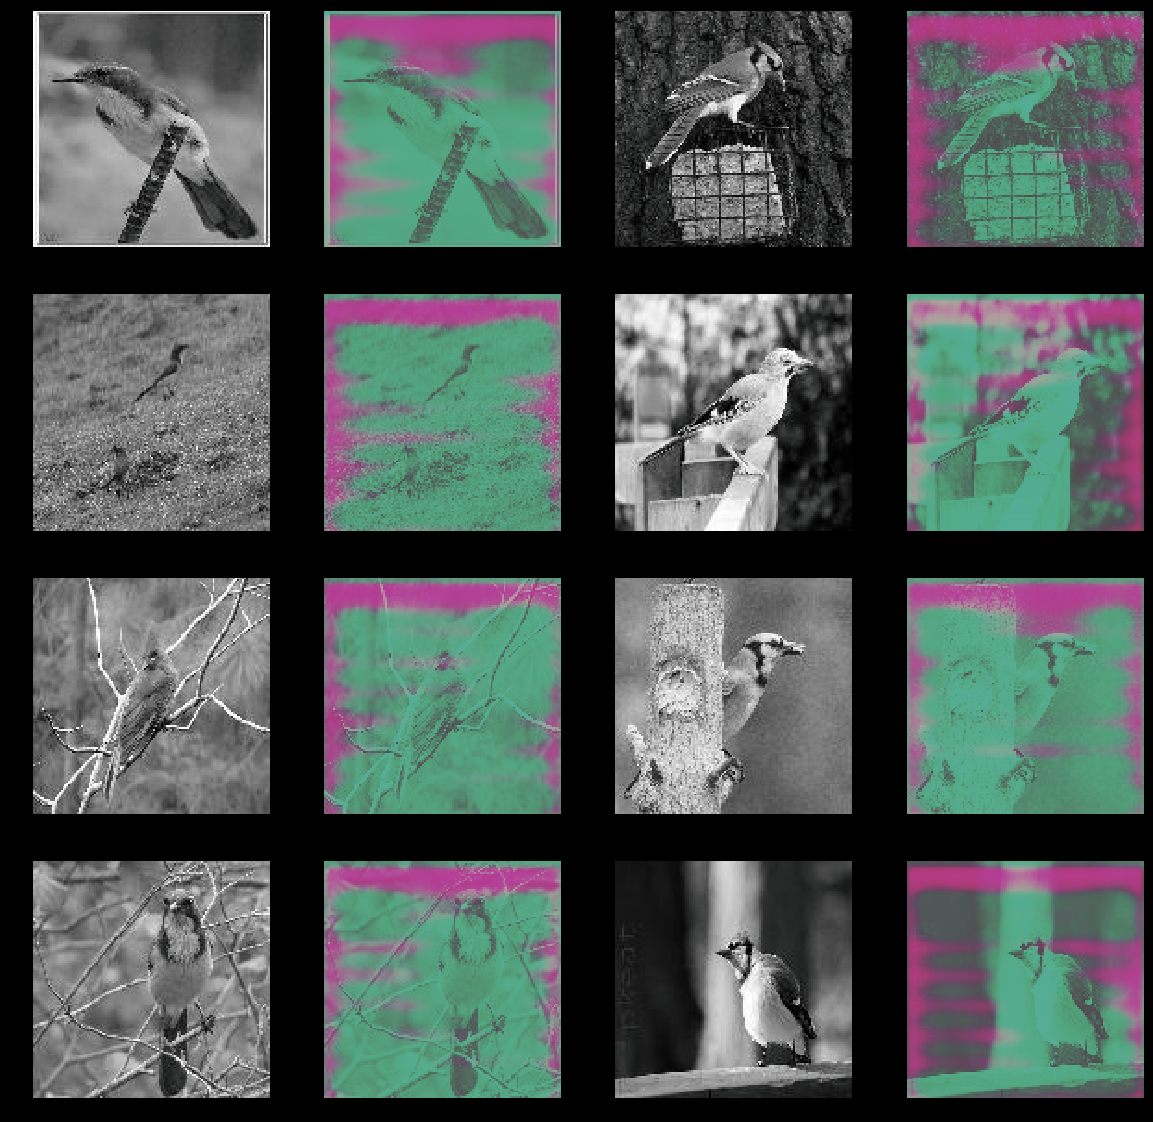

  0%|          | 195/52849 [03:03<13:06:18,  1.12it/s]
WDist [-37.29801]; Real Score [-2.67666]; Fake Score [34.62135]; Gen Loss[15.63035]


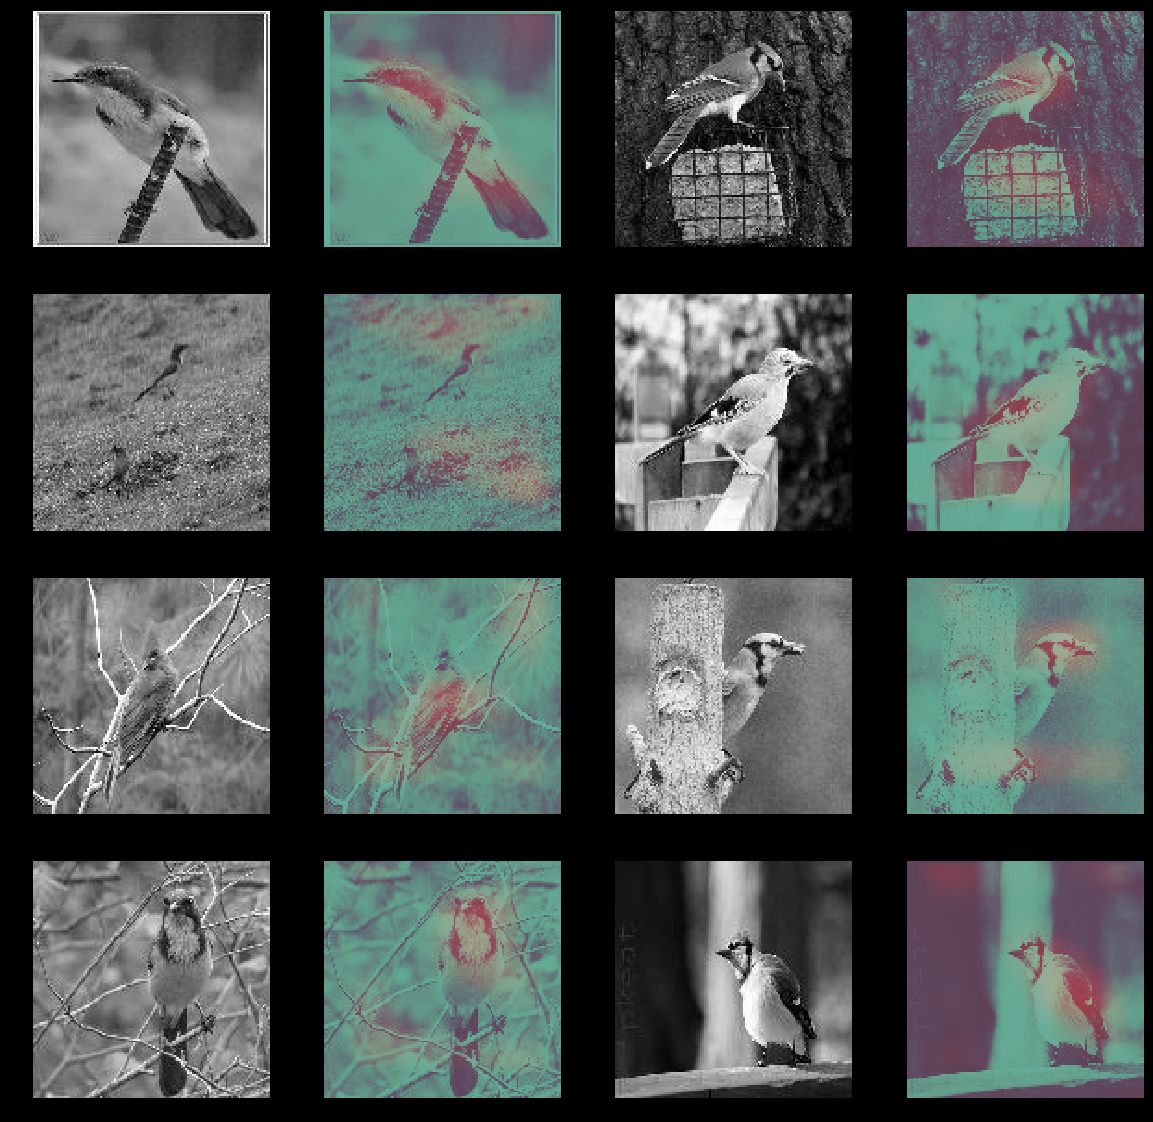

  0%|          | 245/52849 [03:52<13:08:14,  1.11it/s]
WDist [-6.34062]; Real Score [-29.41105]; Fake Score [-23.07043]; Gen Loss[0.98747]


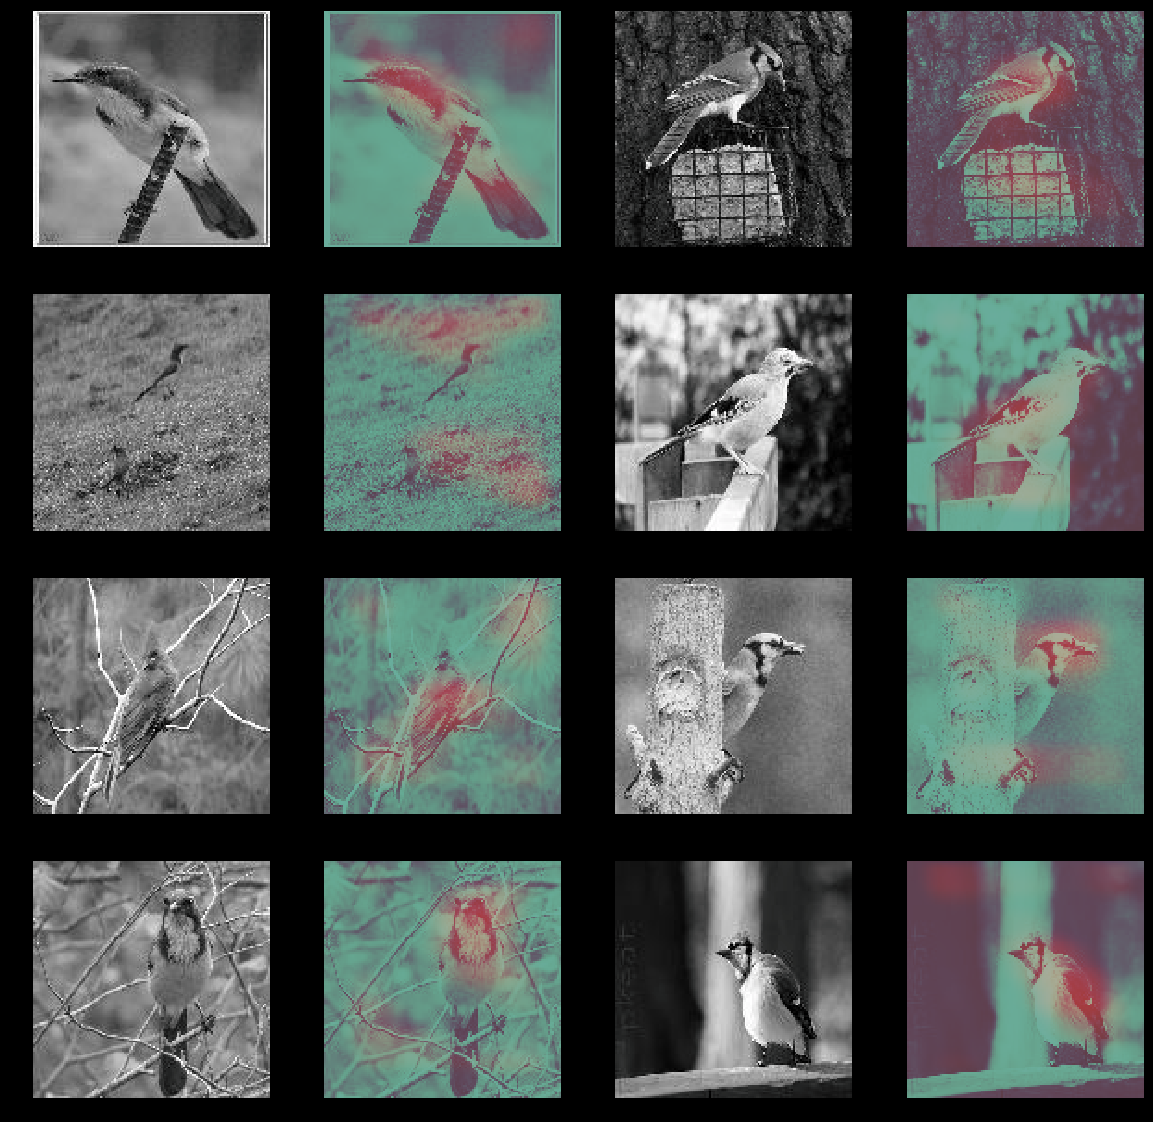

  1%|          | 295/52849 [04:42<13:15:55,  1.10it/s]
WDist [-68.67429]; Real Score [-5.50486]; Fake Score [63.16943]; Gen Loss[-44.79129]


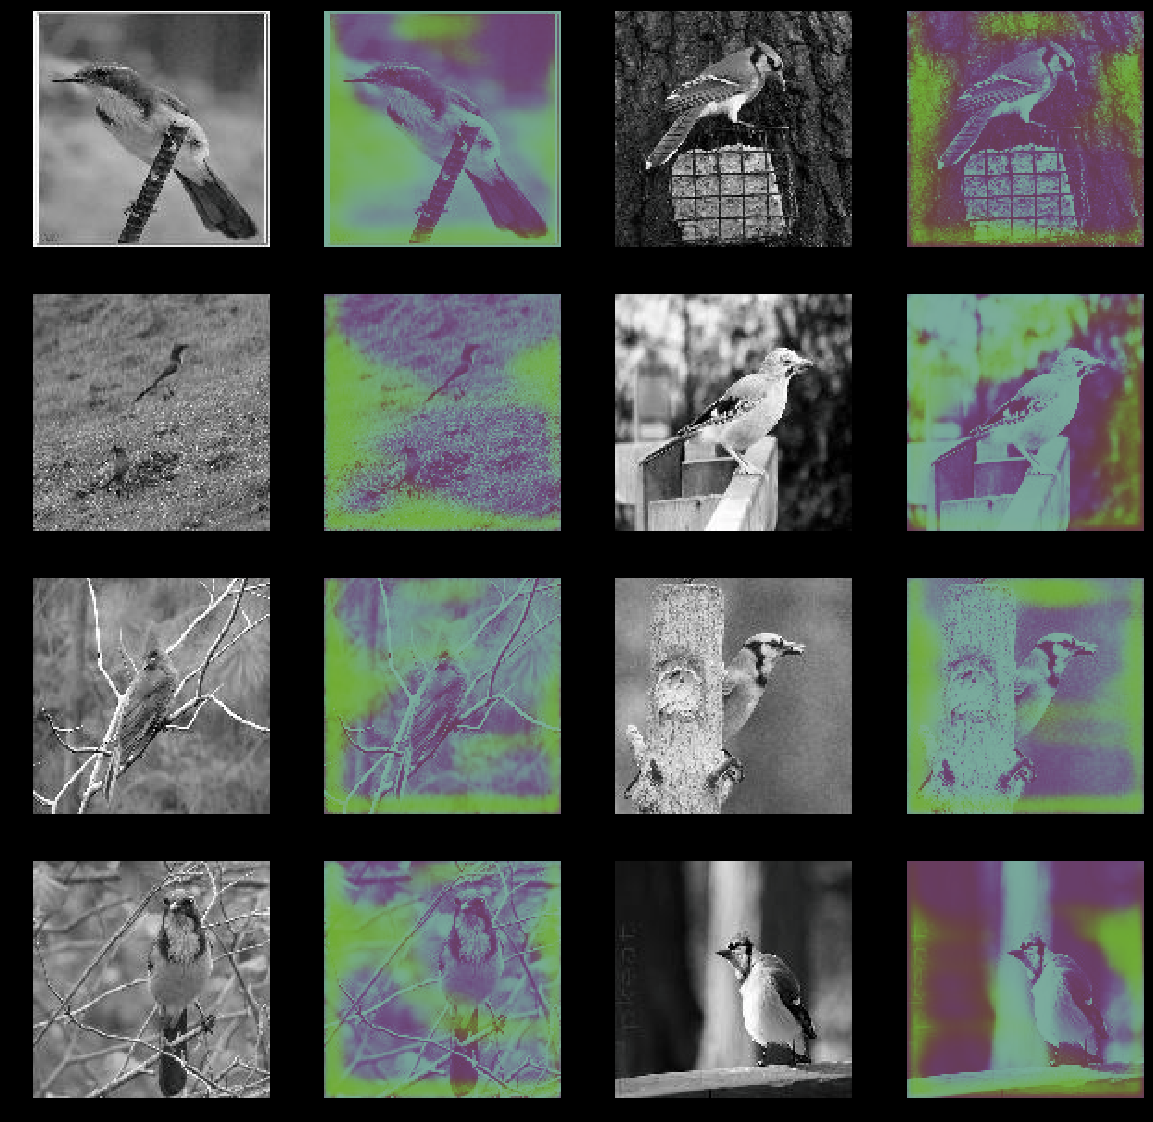

  1%|          | 345/52849 [05:31<13:07:07,  1.11it/s]
WDist [-89.67487]; Real Score [-20.07272]; Fake Score [69.60216]; Gen Loss[-45.78618]


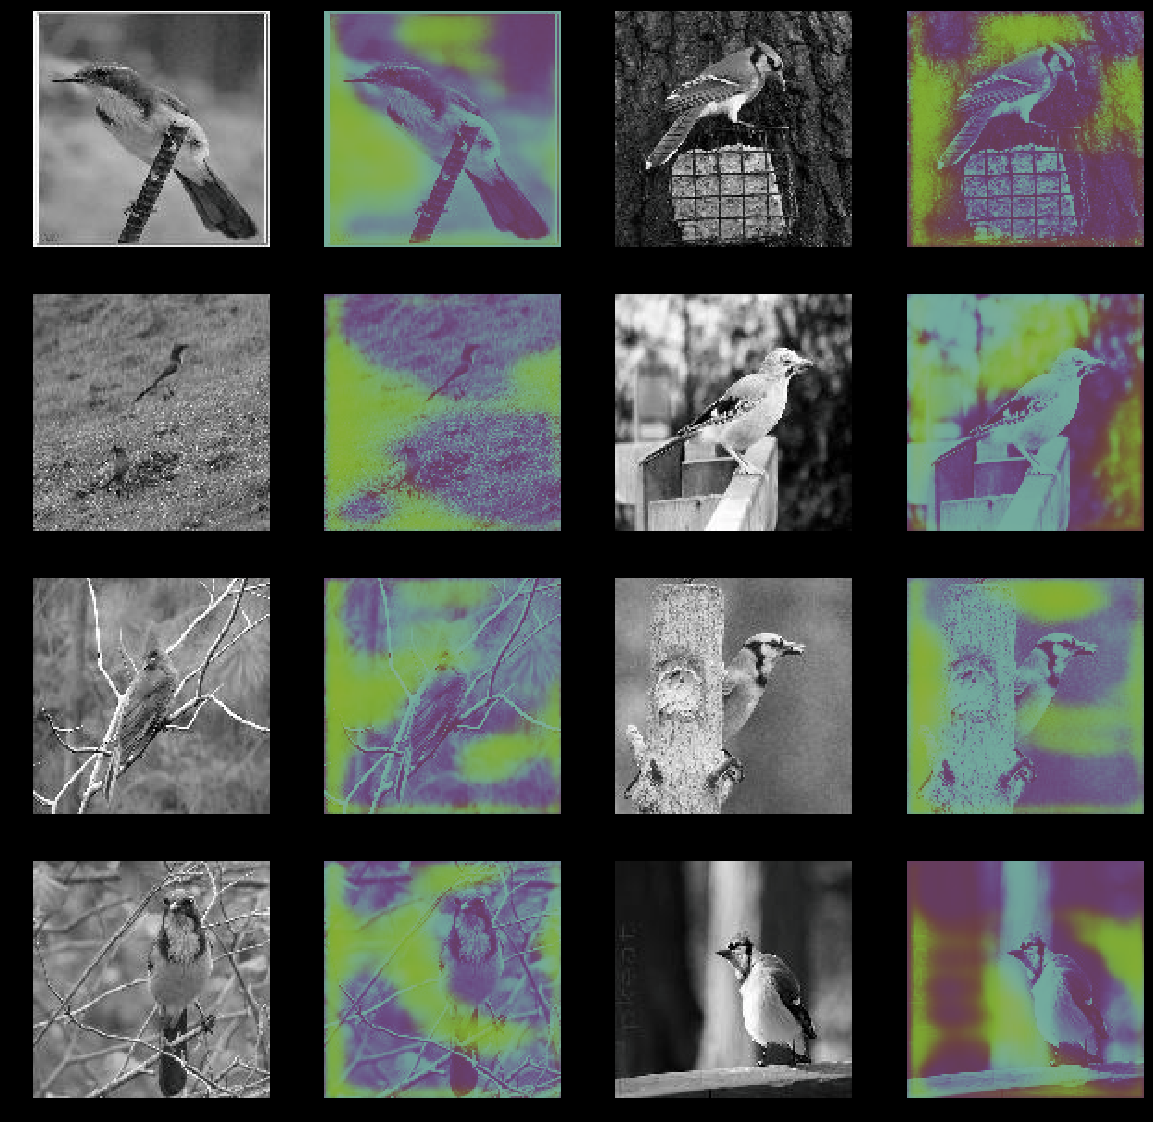

  1%|          | 395/52849 [06:20<13:04:24,  1.11it/s]
WDist [-10.17804]; Real Score [-47.69885]; Fake Score [-37.52081]; Gen Loss[1.24969]


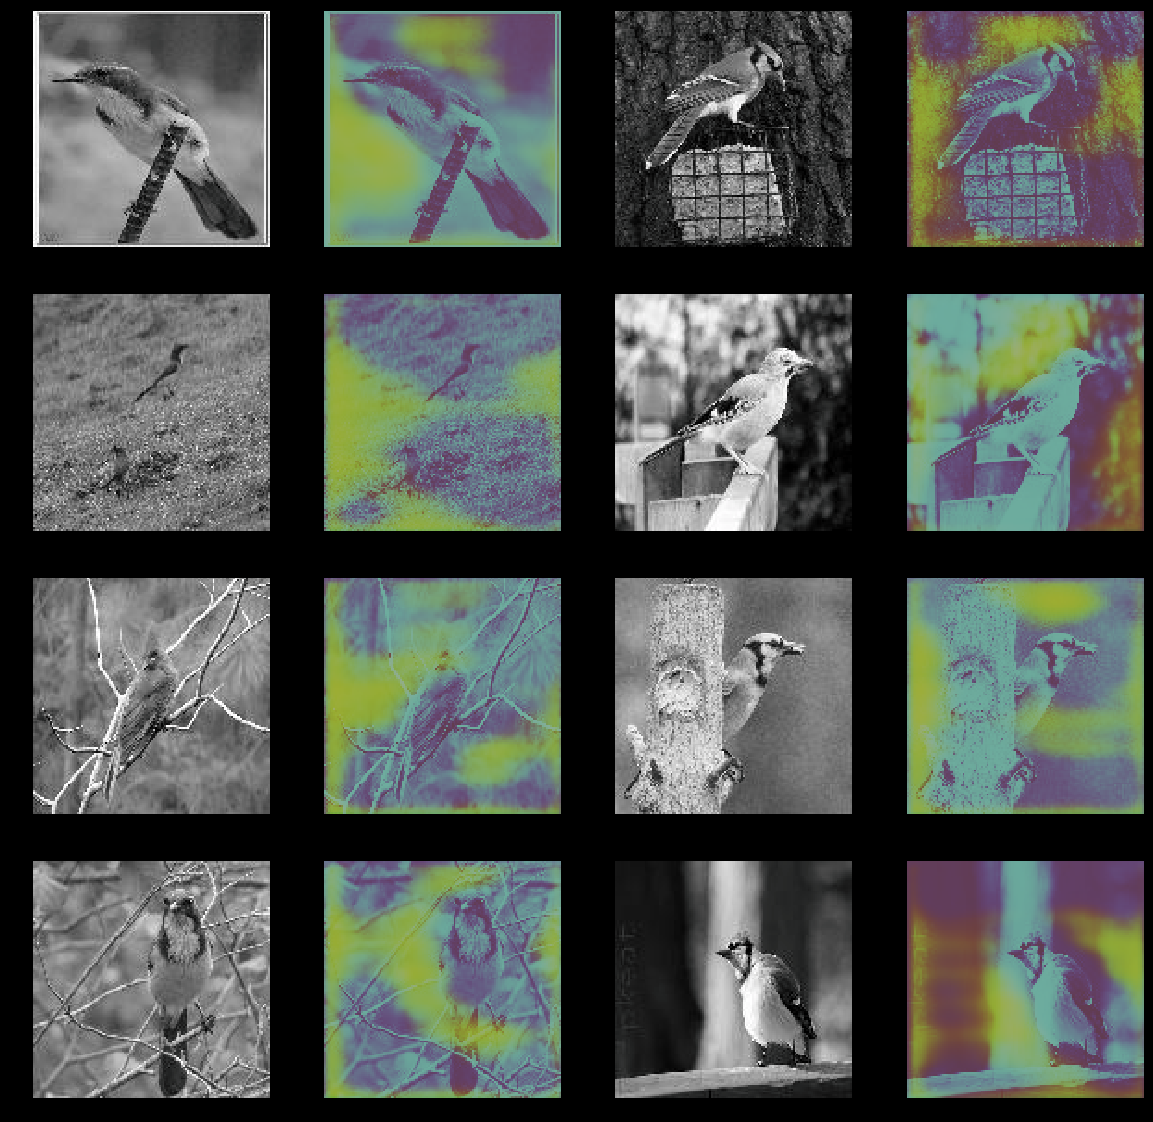

  1%|          | 423/52849 [06:49<14:34:00,  1.00s/it]

In [ ]:
train(1, False)

In [ ]:
visualize(md, netG, 220, 8)